**Fashion retailer e-commerce review classification**

Objective is to use text analysis in order to predict which reviews lead to product recommendation, using two files separated for train and test purposes.

In [ ]:
#notebook is originally created on Google Colab
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files

In [ ]:
uploaded = files.upload() #files are available on github as well

Saving HW4_Text_train_data.csv to HW4_Text_train_data.csv


In [ ]:
train = pd.DataFrame(pd.read_csv('HW4_Text_train_data.csv'))
train.head() #not necessary, just to check the successful file upload

,Review,Recommended
0,"""go to"" please offer a maxi for mature custome...",1
1,"""go to"" tee for sz 10+ women.Women who want so...",1
2,"""long and warm"".These leg warmers are perfect ...",1
3,"""tweed"" dress.I bought this dress for my siste...",1
4,#1 stunna.I am in lust with this fabulous dres...,1


In [ ]:
uploaded = files.upload()

Saving HW4_Text_test_data.csv to HW4_Text_test_data.csv


In [ ]:
test = pd.DataFrame(pd.read_csv('HW4_Text_test_data.csv'))
test.head() #not necessary, just to check the successful file upload

,Review,Recommended
0,"""beach business"".Great for the beachy business...",1
1,"""formal pajamas"".These are super comfy and so ...",1
2,"""perfect with jeans"".Great with leggings.perfe...",1
3,"""won't stretch"" tags are misleading.The tag on...",1
4,$200 piece of polyester.A $200 piece of polyes...,0


In [ ]:
#read the train and the test files into two different data frames. Renamed reviews and recommendations as X and y variables.
review_train=train['Review']
y_train=train['Recommended']
review_test=test['Review']
y_test=test['Recommended']

In [ ]:
#used an already existing code block for visualizing top keywords associated with positive and negative reviews
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

Model #1) Logistic Regression with default parameters. Using Count Vectorizer for text vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bag = CountVectorizer().fit(review_train)
X_train=bag.transform(review_train)
X_test=bag.transform(review_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
log1=LogisticRegression(max_iter=1000).fit(X_train, y_train)
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
y_pred=log1.predict(X_test)
print(roc_auc_score(y_test, y_pred))

Mean cross-validation accuracy: 0.89


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


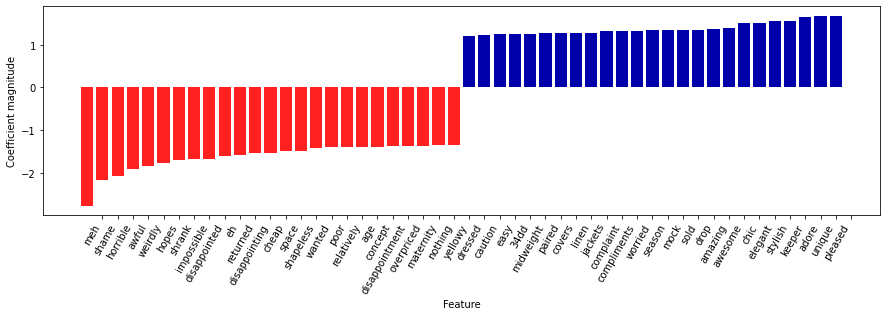

In [ ]:
#called the above visualization function for a high level keyword analysis
coefs = LogisticRegression().fit(X_train,y_train).coef_
feature_names = bag.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=25)

Model #2) Logistic Regression with default parameters, change the vectorization to Tfidf Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df=5, norm=None).fit(review_train)
X_train = vect.transform(review_train)
X_test = vect.transform(review_test)

In [ ]:
log2=LogisticRegression(max_iter=1000).fit(X_train, y_train)
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
y_pred=log2.predict(X_test)
print(roc_auc_score(y_test, y_pred))

Mean cross-validation accuracy: 0.87


Higher ROC score is observed in the model 1 with Count Vectorizer model

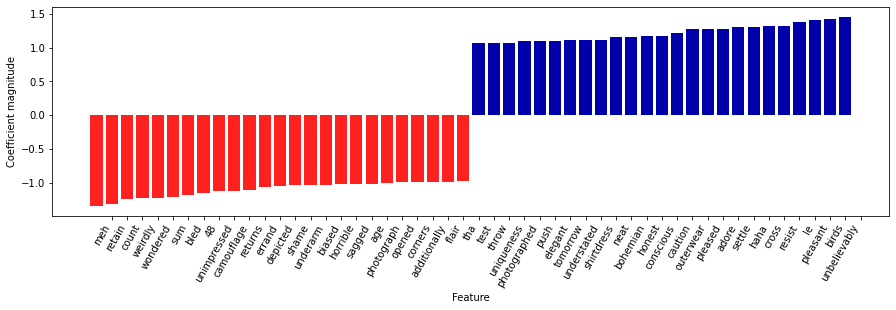

In [ ]:
coefs = LogisticRegression(max_iter=1000).fit(X_train,y_train).coef_
feature_names = vect.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=25)

Model #3) Logistic Regression with n-grams Vectorizer, keeping bi-grams only

In [ ]:
cv_ngram = CountVectorizer(ngram_range=(2, 2)).fit(review_train)
X_train = cv_ngram.transform(review_train)
X_test = cv_ngram.transform(review_test)
log3=LogisticRegression(max_iter=1000).fit(X_train, y_train)
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
y_pred=log3.predict(X_test)
print(roc_auc_score(y_test, y_pred))

Highest ROC score is still from model1.

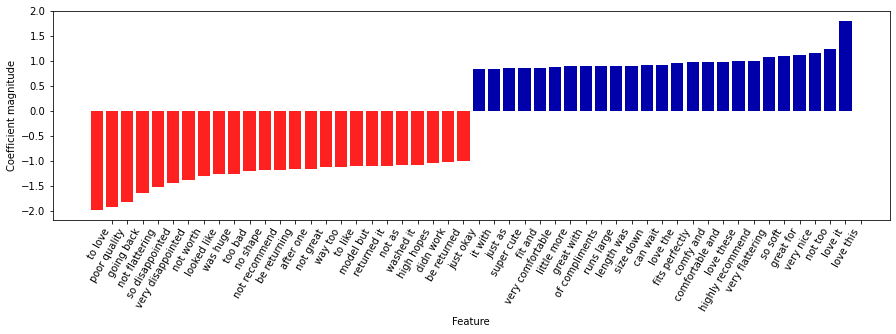

In [ ]:
coefs = LogisticRegression(max_iter=1000).fit(X_train,y_train).coef_
feature_names = cv_ngram.get_feature_names()
visualize_coefficients(coefs, feature_names, n_top_features=25)

Model #3) Random Forest Classifier with Count Vectorizer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X_train=bag.transform(review_train)
X_test=bag.transform(review_test)
forest=RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
scores = cross_val_score(RandomForestClassifier(n_estimators=100), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
y_pred = forest.predict(X_test)
print(roc_auc_score(y_test, y_pred))

Mean cross-validation accuracy: 0.84


Out of 4 model built, decided to continue with Model1 which has the best ROC score.